This notebook demonstrates quantum chemistry calculations on ByteDance Cloud (火山引擎). The service is currently for demonstration only. 

> ⚠️ **Warning**:
- The storage is public. DO NOT upload your confidential data for testing.
- Each user is limited to run 100 GPU hours.

In [1]:
!pip3 install qcclient-ISTCP2024 --upgrade

Defaulting to user installation because normal site-packages is not writeable


# A simple example
## Prepare quantum chemistry tasks for a single job submission

Only two types of jobs are supported at this point
* Single-point energy calculation (sp), including force and Hessian calculations
* Geometry optimization (opt), w/ or w/o constraints.

In [2]:
from qcclient import QCJob, QCConfig

# Dataset in Bohrium. It can be replaced with local directories.
input_dir = "./dataset/h2o/"
molecules = ["h2o.xyz"]
job = QCJob(
    config=QCConfig(qc_job_type="sp"),    # customize config for different quantum chemistry protocols
    input_dir=input_dir, 
    name='ISTCP2024-demo1', 
    molecules=molecules)

One can update the dict for different quantum chemistry protocals. Please refer to https://github.com/pyscf/gpu4pyscf/blob/master/gpu4pyscf/drivers/dft_driver.py

By default, the calculation will be executed with the following configuration
```json
config = {
    'xc': 'b3lyp',
    'basis': 'def2-tzvpp',
    'with_df': True,
    'with_grad': True,
    'with_hess': True
}
```

For geometry optimization tasks, please refer to https://github.com/pyscf/gpu4pyscf/blob/master/gpu4pyscf/drivers/opt_driver.py

## Submit the job

In [3]:
job.submit(check=False)
print(f"job_id={job.job_id}")

job_id=178


## Download results
For each task, three files are saved in one folder
* '*_pyscf.log': PySCF log file, increase 'verbose' in config for more information.
* '*_serverless.log': Scheduler stdout log file.
* '*_pyscf.h5': Main calculated results

In [4]:
# Download the results to the current directory
result_dir = './ISTCP2024_demo1/'
job.pull_output(local_dir=result_dir)          # Downloads begin only when all tasks are completed.
output_dir = f'{result_dir}/jobs/{job.label}/output'

In [5]:
! pip3 install h5py

Defaulting to user installation because normal site-packages is not writeable


## Display the results

In [6]:
import h5py
with h5py.File(output_dir+'/h2o/h2o_pyscf.h5', 'r') as file:
    # Get the dataset
    print(f'Total energy (Hartree):')
    print(file['e_tot'][()])
    print(f'Gradient (Hartree/Bohr):')
    print(file['grad'][()])
    print(f'Hessian (Hartree/Bohr^2):')
    print(file['hess'][()])
    

Total energy (Hartree):
-76.46325514905227
Gradient (Hartree/Bohr):
[[ 0.02786414  0.0035512  -0.00024171]
 [-0.01029678 -0.03530189 -0.00730281]
 [-0.01756746  0.0317507   0.00754458]]
Hessian (Hartree/Bohr^2):
[[ 0.35683067 -0.01974901 -0.01634353 -0.14333742 -0.1170398  -0.02071004
  -0.21349825  0.13678693  0.03705455]
 [-0.01974901  0.53015597  0.11041693 -0.16964706 -0.30022937 -0.05629708
   0.18939427 -0.22989969 -0.05411732]
 [-0.01634353  0.11041692  0.05032282 -0.03215121 -0.05821166 -0.02447275
   0.04849574 -0.05220274 -0.02587659]
 [-0.14333742 -0.16964706 -0.03215121  0.13273228  0.13988639  0.02623775
   0.01060534  0.02976036  0.0059132 ]
 [-0.1170398  -0.30022937 -0.05821166  0.13988641  0.31973689  0.0605879
  -0.02284692 -0.01950784 -0.00237615]
 [-0.02071004 -0.05629708 -0.02447275  0.02623775  0.06058789  0.02996484
  -0.00552798 -0.00429074 -0.00549091]
 [-0.21349825  0.18939427  0.04849574  0.01060534 -0.02284692 -0.00552798
   0.2028935  -0.16654708 -0.0429676 

# An example for geometry optimization

In [7]:
from qcclient import QCJob, QCConfig

# Dataset in Bohrium. It can be replaced with local directories.
input_dir = "./dataset/h2o"
molecules = ["h2o.xyz"]
job = QCJob(
    config=QCConfig(qc_job_type="opt"),
    input_dir=input_dir, 
    name='ISTCP2024-demo2',
    molecules=molecules)
job.submit(check=False)
print(f"job_id={job.job_id}")

job_id=181


## Download results for an optimization job
If the optimization succeed, six files are saved in one folder:
* '*_geometric.log': Geometric log file, recording the optimization process.
* '*_hist.h5': Geometry, energy and gradient for each optimization step.
* '*_opt.xyz': Optimized geometry.
* '*_pyscf.log': PySCF log file, increase 'verbose' in config for more information.
* '*_serverless.log': Scheduler stdout log file.
* '*_success.txt': An indicator of a successful optimization. This file is missing if the optimization did not converge.

In [8]:
result_dir = './ISTCP2024_demo2/'
job.pull_output(local_dir=result_dir)
output_dir = f'{result_dir}/jobs/{job.label}/output'

In [9]:
import os, h5py
bohr2angstrom = 0.529177210903

# Print optimization trajectory
molecule = molecules[0][:-4] # Remove .xyz
h5file = os.path.join(output_dir, f'{molecule}/{molecule}_hist.h5')
with h5py.File(h5file, 'r') as h5_file:
    for step in h5_file.keys():
        if step.startswith("step"):
            print(step + " energy (Hartree): " + str(h5_file[step]["energy"][()]))
            print(step + " geometry (Angstrom): " + str(h5_file[step]["coords"][()] * bohr2angstrom))

step_0 energy (Hartree): -76.46325514905222
step_0 geometry (Angstrom): [[ 99.814  100.835  101.232 ]
 [ 99.3292  99.9768 101.063 ]
 [ 99.1516 101.561  101.414 ]]
step_1 energy (Hartree): -76.46666473485362
step_1 geometry (Angstrom): [[ 99.82412523 100.83596779 101.2318411 ]
 [ 99.31751181 100.0360753  101.07631598]
 [ 99.15316595 101.50075681 101.40084064]]
step_2 energy (Hartree): -76.4667050274951
step_2 geometry (Angstrom): [[ 99.81988833 100.83548285 101.23188942]
 [ 99.32041379 100.02934312 101.07474571]
 [ 99.15451082 101.50796979 101.40236032]]
step_3 energy (Hartree): -76.46670559930976
step_3 geometry (Angstrom): [[ 99.81937333 100.8354206  101.23189386]
 [ 99.32066981 100.02942946 101.07475435]
 [ 99.15478007 101.50794212 101.4023442 ]]


# A more realistic example
We use this example reproducing the result in https://arxiv.org/abs/2404.09452

In [10]:
from qcclient import QCJob, QCConfig

# Dataset in Bohrium. It can be replaced with local directories.
input_dir = "./dataset/organic"
config = QCConfig(qc_job_type="sp")
config['with_hess'] = False # turn off hessian calculation for fast demo
job = QCJob(
    config=config,
    input_dir=input_dir, 
    name='ISTCP2024-demo3')
job.submit(check=False)
print(f"job_id={job.job_id}")


job_id=182


## Check job status

In [13]:
# Check the status of the job.
# This code cell is non-blocking and you can run this cell repeatedly.
# The next code cell will block until all computation finishes.

print("Status of the job, including all tasks: " + job.client.get_job_status(job.job_id))
print()

task_summary = job.client.get_job_summary(job.job_id)
if task_summary is not None:
    print("Status of each task (each molecule):")
    print("| status     | count |\n----------------------")
    for status in task_summary:
        print(f"| {status:10s} | {task_summary[status]:5d} |")
    print()


Status of the job, including all tasks: running

Status of each task (each molecule):
| status     | count |
----------------------
| pending    |     5 |
| running    |     2 |
| succeed    |     6 |



One of the tasks in the above job is intended to be failed.

In [14]:
result_dir = './ISTCP2024_demo3/'
job.pull_output(local_dir=result_dir)                # This will take a while.
output_dir = f'{result_dir}/jobs/{job.label}/output'

Job status is not 'succeed': failed


## Performance benchmark

Here we show the performance benchmark of DFT energy and gradient calculations on molecules with varying sizes.

In [15]:
import os, h5py

molecules = [
 '020_Vitamin_C',
 '031_Inosine',
 '033_Bisphenol_A',
 '037_Mg_Porphin',
 '042_Penicillin_V',
 '045_Ochratoxin_A',
 '052_Cetirizine',
 '057_Tamoxifen',
 '066_Raffinose',
 '084_Sphingomyelin',
 '095_Azadirachtin',
 '113_Taxol'
]

scf_time = []
grad_time = []
for folder in molecules:
    mol_name = folder
    task_folder = os.path.join(output_dir, folder)
    h5file = os.path.join(task_folder, mol_name+'_pyscf.h5')
    if not os.path.exists(h5file):
        continue
    with h5py.File(h5file, 'r') as h5_file:
        scf_time.append(h5_file['scf_time'][()])
        grad_time.append(h5_file['grad_time'][()])



In [16]:
!pip3 install matplotlib

Defaulting to user installation because normal site-packages is not writeable


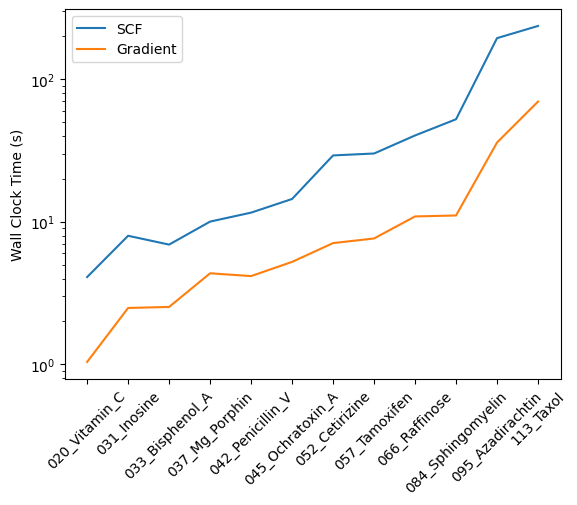

In [17]:
import matplotlib.pyplot as plt
import numpy as np
plt.plot(np.asarray(scf_time), label='SCF')
plt.plot(np.asarray(grad_time), label='Gradient')
plt.xticks(ticks=np.arange(len(scf_time)), labels=molecules, rotation=45)
plt.ylabel('Wall Clock Time (s)')
plt.legend()
plt.yscale('log')

# More control options

## Killing a job

In the following four code cells we lunch two long tasks in one job, and then kill the job.

In [18]:
from qcclient import QCJob, QCConfig

input_dir = "./dataset/organic/"
config = QCConfig(qc_job_type="sp")
config['with_hess'] = False # turn off hessian calculation for fast demo
molecules = ['095_Azadirachtin.xyz', '113_Taxol.xyz']
job = QCJob(
    config=config,
    input_dir=input_dir, 
    name='ISTCP2024-demo4',
    molecules=molecules)
job.submit(check=False)
print(f"job_id={job.job_id}")

job_id=183


In [19]:
print("Status of the job, including all tasks: " + job.client.get_job_status(job.job_id))
print("Status of each task (each molecule): " + str( job.client.get_job_summary(job.job_id) ))
print()

Status of the job, including all tasks: running
Status of each task (each molecule): {'running': 2}



In [20]:
job.client.stop_job(job.job_id)

In [21]:
print("Status of the job, including all tasks: " + job.client.get_job_status(job.job_id))
print("Status of each task (each molecule): " + str( job.client.get_job_summary(job.job_id) ))
print()

Status of the job, including all tasks: stopped
Status of each task (each molecule): {'stopped': 2}



In [22]:
# # Rerun failed job
# job.client.retry_failed(job.job_id)